# Libraries

##  Remove warnings

In [97]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [98]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pickle
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow 
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## CUDA

In [99]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)
except:
    print('[INFO] Not GPU found')

## Neural networks parameters

In [100]:
Lag        =   12
Horizon    =    2
#
epochs     =  100
batch_size =  128

# Data handling

## Import data


In [101]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Data concern the concentration from a mine in Norway
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

 

# # Parameters
#
filename   = '../metadata/7-kanal-1.csv'

Transformation  = True
Scaling         = 'Standard'



# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.32 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


In [102]:
# # Parameters
# #
# filename   = '../Data/D-6-It.csv'

# Transformation  = True
# Scaling         = 'Standard'




# # Start timer
# #
# start = time.time()

# # Load data
# #
# df = pd.read_csv(filename, 
#                  sep = ',')


# # Rename columns
# #
# df = df.rename(columns = {'created_at' : 'Date',
#                           'field1' : 'Temperature',
#                           'field2' : 'Humidity',
#                           'field3' : 'PM2.5',
#                           'field4' : 'PM10',
#                           'field5' : 'NO2',
#                           'field6' : 'CO',
#                           'field7' : 'NH4',})



# # End timer
# #
# print('[INFO] Time: %.2f' % (time.time() - start))

# df.head( 3 )

## Preprocess data

### Set index

In [103]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('10min').mean() 
# df = pd.DataFrame( df[['Temperature', 'Humidity', 'NO2', 'CO']] )

# The last feature is the target variable
df = pd.DataFrame( df[ ['NO2', 'CO'] ] )
# df = pd.DataFrame( df[ 'CO' ] )


df.head(3)

,NO2,CO
Date,,
2022-02-19 00:00:00,168.631579,240.710526
2022-02-19 00:10:00,135.394737,227.473684
2022-02-19 00:20:00,141.447368,229.526316


In [104]:
# Set target series/Series which will be forecasted
# 
targetSeries = df.columns[-1]

# Set all other utilized features
Features = df.columns[:-1]

### Include MA-based features

In [105]:
# df['MA6']  = df[ targetSeries ].rolling(6).mean()
# df['MA12'] = df[ targetSeries ].rolling(12).mean()

In [106]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ] 
df_test  = df[ idx: ] 

### Visualization

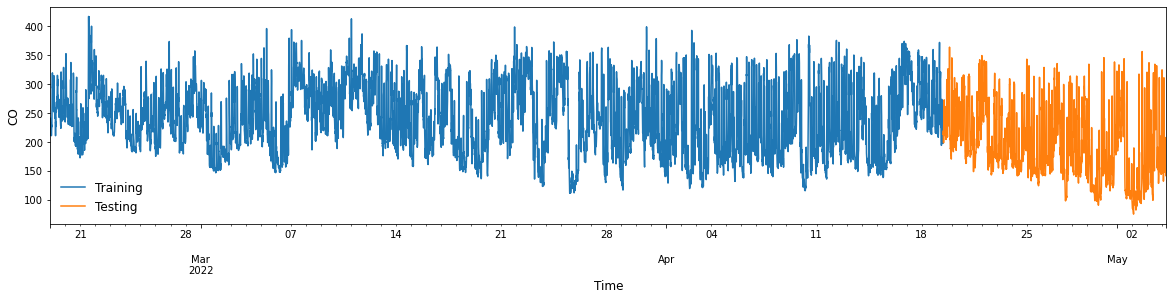

In [107]:
plt.figure( figsize = (20, 4) );
#
df_train[ targetSeries ].plot()
df_test[ targetSeries ].plot()
#
plt.legend(['Training', 'Testing'], fontsize = 12, frameon = False);
plt.ylabel( targetSeries, size = 12);
plt.xlabel( 'Time', size = 12);

### Fixing Lag

In [108]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [109]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(abs( -df.min().min() ) + 1.0, 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)

    # # Transformation parameter
    # #
    # d = {'parameter': VALUE}

    # import json
    # with open('checkpoints/Transformation.json', 'w') as fp:
    #     json.dump(d, fp)
    # print('[INFO] Parameters saved')

else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


In [110]:
import pickle

if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()
    
    df_train[ Features ] = scaler.fit_transform( df_train[ Features ].to_numpy().reshape(-1,1) )
    df_test[ Features ]  = scaler.transform( df_test[ Features ].to_numpy().reshape(-1,1) )

    # # Save Scaler
    # #
    # filename = 'checkpoints/Feature_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Feature scaler saved in ', filename)


    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
    # # Save Scaler
    # #
    # filename = 'checkpoints/Target_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Target scaler saved in ', filename)

    
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
    
    df_train[ Features ] = scaler.fit_transform( df_train[ Features ].to_numpy().reshape(-1,1) )
    df_test[ Features ]  = scaler.transform( df_test[ Features ].to_numpy().reshape(-1,1) )

    # # Save Scaler
    # #
    # filename = 'checkpoints/Feature_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Feature scaler saved in ', filename)


    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
    # # Save Scaler
    # #
    # filename = 'checkpoints/Target_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Target scaler saved in ', filename)
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    # Set scaler
    #
    scaler = StandardScaler()
    
    df_train[ Features ] = scaler.fit_transform( df_train[ Features ].to_numpy().reshape(-1,1) )
    df_test[ Features ]  = scaler.transform( df_test[ Features ].to_numpy().reshape(-1,1) )

    # # Save Scaler
    # #
    # filename = 'checkpoints/Feature_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Feature scaler saved in ', filename)


    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
    # # Save Scaler
    # #
    # filename = 'checkpoints/Target_scaler.pkl'
    # pickle.dump(scaler, open(filename, 'wb'))
    # print('[INFO] Target scaler saved in ', filename)       
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   

[INFO] Scaling: Standard


## Create Training/Testing data

In [111]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1, includeDate = False):
    
    if (targetSeries is None):
        print('[INFO] Target series is not defined')
        return (None, None, None)
    
    dataX, CurrentValue, dataY = [], [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):

        # Check for NaN values
        if (df[i:i + Lag + Horizon].dropna().shape[0] != df[i:i + Lag + Horizon].shape[0]): continue
        
        # Instances: Lag-d differences
        Instance  = (df.iloc[i+Lag-1] - df.iloc[i:(i+Lag-1)]).to_numpy().tolist() 
        
        # Include date info
        if (includeDate):            
            myDate = [ np.sin(df[i:(i+Lag-1)].index.hour + df[i:(i+Lag-1)].index.minute / 60 ).tolist(), 
                       np.cos(df[i:(i+Lag-1)].index.hour + df[i:(i+Lag-1)].index.minute / 60 ).tolist() ]
            myDate = np.asarray( myDate ).T
            #
            Instance = np.concatenate([Instance, myDate], axis = -1)

        # Current value
        CurrentValue.append( df[ targetSeries ].to_numpy()[i+Lag-1] )
        # Append instance
        dataX.append( Instance ) 
                
        # Target Instance
        Instance = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon])
        # Append instance
        dataY.append( Instance )

        
    return ( np.array(dataX), np.array(dataY), np.array(CurrentValue) )

In [112]:
trainX, trainY, _                = create_dataset(df           = df_train, 
                                                  Lag          = Lag, 
                                                  Horizon      = Horizon, 
                                                  targetSeries = targetSeries,
                                                  includeDate  = False,
                                                  overlap      = 1,)

testX,  testY, test_CurrentValue = create_dataset(df           = df_test, 
                                                  Lag          = Lag, 
                                                  Horizon      = Horizon, 
                                                  targetSeries = targetSeries,
                                                  includeDate  = False,                                                
                                                  overlap      = Horizon,)


# trainX = np.expand_dims(trainX, axis=-1)
# testX  = np.expand_dims(testX, axis=-1)
print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 1070/1070 [00:01<00:00, 589.93it/s]

Training instances:     8545
Testing instances:      1070


# Forecasting model: NBeats

In [113]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## Setup model

In [114]:
from utils.NBeats_Keras import NBeatsNet


model = NBeatsNet(stack_types            = (NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                  input_dim              = trainX.shape[2],
                  forecast_length        = Horizon, 
                  backcast_length        = trainX.shape[1], # Lag-1
                  hidden_layer_units     = 128,
                  nb_blocks_per_stack    = 4,
                  share_weights_in_stack = False,
                  activation_function    = 'relu')

## Training parameters

In [115]:
# Define metrics
#
metrics = [
            MeanAbsoluteError(name = "MAE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]


model.compile(loss      = 'mse', 
              optimizer = Adam(learning_rate = 5.e-4), 
              metrics   = metrics)

In [116]:
# Checkpoint
#
checkpoint = ModelCheckpoint("checkpoints/NBeats_Diff.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.5,
                                   patience    = 10)

## Training process

In [117]:
# Start clock
#
start = time.time()


score = model.fit(trainX, trainY, 
                  epochs           = epochs, 
                  batch_size       = batch_size, 
                  callbacks        = [checkpoint, earlystopping, lrs_scheduler],
                  verbose          = True, 
                  shuffle          = True,
                  validation_split = 0.2)


# Terminate clock
#
stop = time.time()
print('[INFO] Time %.2f' % (stop - start))

Epoch 1/100
54/54 [==============================] - 11s 57ms/step - loss: 0.1841 - MAE: 0.2820 - RMSE: 0.4291 - val_loss: 0.2491 - val_MAE: 0.3272 - val_RMSE: 0.4991 - lr: 5.0000e-04
Epoch 2/100
54/54 [==============================] - 1s 22ms/step - loss: 0.1789 - MAE: 0.2789 - RMSE: 0.4230 - val_loss: 0.2509 - val_MAE: 0.3363 - val_RMSE: 0.5009 - lr: 5.0000e-04
Epoch 3/100
54/54 [==============================] - 2s 34ms/step - loss: 0.1778 - MAE: 0.2779 - RMSE: 0.4217 - val_loss: 0.2465 - val_MAE: 0.3270 - val_RMSE: 0.4965 - lr: 5.0000e-04
Epoch 4/100
54/54 [==============================] - 1s 21ms/step - loss: 0.1776 - MAE: 0.2789 - RMSE: 0.4215 - val_loss: 0.2499 - val_MAE: 0.3223 - val_RMSE: 0.4999 - lr: 5.0000e-04
Epoch 5/100
54/54 [==============================] - 1s 22ms/step - loss: 0.1777 - MAE: 0.2778 - RMSE: 0.4215 - val_loss: 0.2470 - val_MAE: 0.3268 - val_RMSE: 0.4969 - lr: 5.0000e-04
Epoch 6/100
54/54 [==============================] - 2s 34ms/step - loss: 0.1773 - M

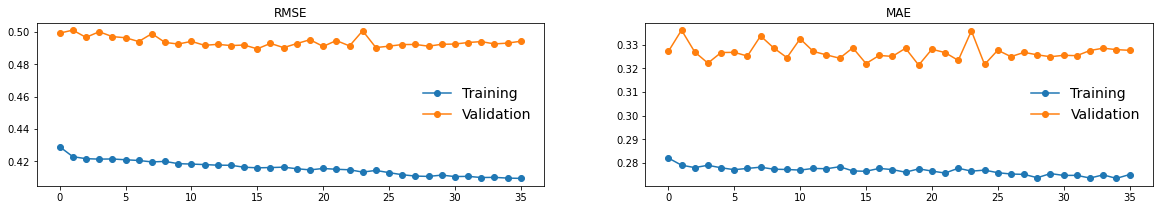

In [118]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 3) )

# Plot RMSE
#
ax[0].plot( score.history['RMSE'], marker = 'o');
ax[0].plot( score.history['val_RMSE'], marker = 'o');
ax[0].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[0].set_title('RMSE');

# Plot RMSE
#
ax[1].plot( score.history['MAE'], marker = 'o');
ax[1].plot( score.history['val_MAE'], marker = 'o');
ax[1].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[1].set_title('MAE');

## Load optimized model

In [119]:
# Load the best model
#
model.load_weights('checkpoints/NBeats_Diff.hdf5')

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [120]:
# Get predictions
#
pred = model.predict( testX )

pred = pred.squeeze(-1)

### Inverse "Lag-d Diff" transformation

In [121]:
for i in range( Horizon ):
    testY[:, i] = test_CurrentValue - testY[:, i]
    pred[:, i]  = test_CurrentValue - pred[:, i]

### Apply inverse scaling/transformation

In [122]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE

### Calculate Performance on Testing set


In [123]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]


    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
#     print('Horizon: ', i+1)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f RMSE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, RMSE, SMAPE, R2) )

[INFO] Feature:  CO
------------------------------------------------
Horizon:  1 MAE 15.29 RMSE 24.89 SMAPE:  7.36 R2: 0.84
Horizon:  2 MAE 25.37 RMSE 38.62 SMAPE: 12.38 R2: 0.61


### Reliability evaluation

[INFO] Feature:  CO
------------------------------------------------


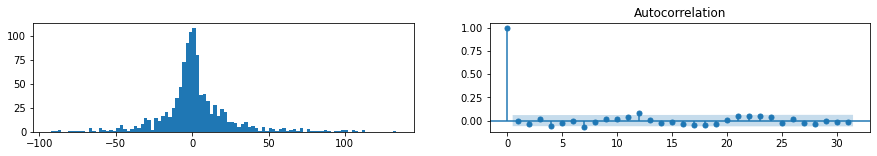

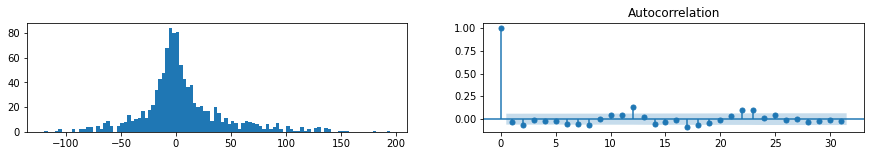

In [124]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
            
            

            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices[targetSeries] - Prices['Prediction']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )       

## Visualization

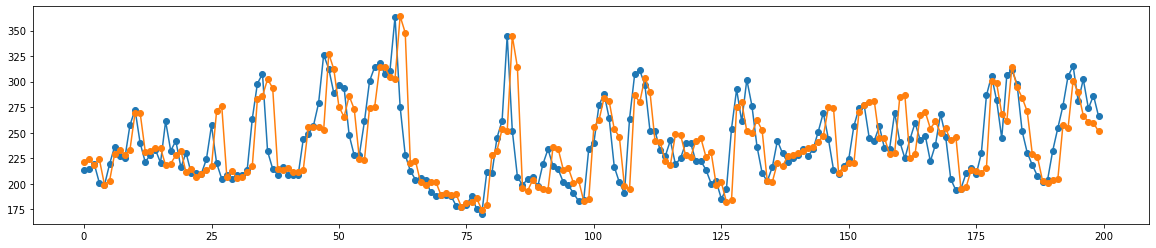

In [125]:
Prices = pd.DataFrame( [] )

Prices[targetSeries] = testY.flatten()
Prices['Prediction'] = pred.flatten()


# Plot results
#
plt.figure( figsize = (20, 4) );
#
Prices[ targetSeries ][:200].plot(color = 'tab:blue', marker = 'o')
Prices[ 'Prediction' ][:200].plot(color = 'tab:orange', marker = 'o')
plt.show();


### Examples

In [126]:
# subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
# plt.figure( figsize = (20, 8) )
# RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]
# RandomInstances = [66, 62, 192, 448, 477, 1035, 34, 408, 860]

# for plot_id, i in enumerate(RandomInstances):

#     plt.subplot(subplots[plot_id])
#     plt.grid()

#     plt.plot(testY[i], color='g', marker = 'o', linewidth = 2)
#     plt.plot(pred[i],  color='r', marker = 'o', linewidth = 2)

#     plt.legend(['Future values', 'Prediction'], frameon = False, fontsize = 12)
#     plt.ylim([90, 260])
# plt.show()

# Store predictions

In [127]:
Outputs = pd.DataFrame( [] )


Outputs[ targetSeries ] = testY.flatten()
Outputs['NBeats_diff'] = pred.flatten()

Outputs.to_csv('Predictions/NBeats_diff.csv')